In [1]:
from glove import Corpus, Glove
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import datetime,time
from flashtext.keyword import KeywordProcessor
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re
import pandas as pd
import numpy as np
import string
import multiprocessing
from nltk.corpus import stopwords
from flashtext.keyword import KeywordProcessor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# libraries for dataset preparation, feature engineering, model training 
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
#from utils.language_models import WordVectorEmbedding
from gensim.test.utils import datapath, get_tmpfile
#import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from sklearn import preprocessing
from pymongo import MongoClient

# Import Translator module from googletrans package
from googletrans import Translator  

#Import seaborn for data exploration
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
sns.set(style="darkgrid")

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
MONGO_HOST = 'localhost'
MONGO_PORT = 27017
DATABASE_NAME='Portfolio'

In [3]:
client_prod = MongoClient(host=MONGO_HOST,port=MONGO_PORT,unicode_decode_error_handler='ignore')
db_prod = client_prod[DATABASE_NAME]
collection_congress = "Election_Congress"
collection_bjp = "Election_BJP"
def getCollection(collection_name):
    return db_prod[collection_name]

In [4]:
col_congress=getCollection(collection_congress)
col_bjp=getCollection(collection_bjp)

In [5]:
df_congress=pd.DataFrame(list(getCollection(collection_congress).find({})))
df_bjp=pd.DataFrame(list(getCollection(collection_bjp).find({})))
print('Total number of tweets for Congress loaded from Mongo : {}'.format(df_congress.shape[0]))
print('Total number of tweets for BJP loaded from Mongo : {}'.format(df_bjp.shape[0]))

Total number of tweets for Congress loaded from Mongo : 16802
Total number of tweets for BJP loaded from Mongo : 18626


### As the first step of basic EDA, we will be removing all null,empty tweets 

In [6]:
df_congress_clean_tweets=df_congress[df_congress['Tweet_cleaned']!='']
df_congress_clean_tweets=df_congress_clean_tweets[~df_congress_clean_tweets['Tweet_cleaned'].isnull()]
df_bjp_clean_tweets=df_bjp[df_bjp['Tweet_cleaned']!='']
df_bjp_clean_tweets=df_bjp_clean_tweets[~df_bjp_clean_tweets['Tweet_cleaned'].isnull()]
print('Total number of Congress tweets after removing empty ones {}'.format(df_congress_clean_tweets.shape[0]))
print('Total number of BJP tweets after removing empty ones {}'.format(df_bjp_clean_tweets.shape[0]))

Total number of Congress tweets after removing empty ones 10490
Total number of BJP tweets after removing empty ones 10669


In [7]:
df_congress_clean_tweets.drop_duplicates('Tweet_cleaned',inplace=True)
df_bjp_clean_tweets.drop_duplicates('Tweet_cleaned',inplace=True)
print('Total number of Congress tweets after removing duplicates {}'.format(df_congress_clean_tweets.shape[0]))
print('Total number of BJP tweets after removing duplicates {}'.format(df_bjp_clean_tweets.shape[0]))

Total number of Congress tweets after removing duplicates 5150
Total number of BJP tweets after removing duplicates 4620


## As we can see, dropping the duplicates almost reduced the count by half. We need to further explore the data and see if there are any other discrepancies still present.. 

In [8]:
df_congress_clean_tweets['party']='congress'
df_bjp_clean_tweets['party']='bjp'

In [9]:
df_bjp_clean_tweets.head()

,Created At,Likes,Location,Name,Retweet,Tweet,Tweet_cleaned,_id,id,party
0,2019-03-28 09:38:37,0,banka,sudhanshu kumar das,0,RT @theskindoctor13: @ANI Shatrughan Sinha ke ...,ANI Shatrughan Sinha ke Congress me aane se ji...,5c9c96235c284c72c0f92f17,1111200911781564416,bjp
1,2019-03-28 09:38:37,0,"Lucknow, India",Ayush Sfi,0,RT @YsakMv: CPI(M) Manifesto 2019 Release. M...,CPI M Manifesto 2019 Release Main Slogans Defe...,5c9c96245c284c72c0f92f18,1111200912255537152,bjp
2,2019-03-28 09:38:37,0,"New Delhi, India",godi_media,0,RT @AisiTaisiDemo: Kuchh bhi mat bolo @abhisar...,Kuchh bhi mat bolo abhisar sharma Uss akhbaar ...,5c9c96255c284c72c0f92f19,1111200913014820864,bjp
3,2019-03-28 09:38:38,0,अंतरिक्ष - स्वर्ग में😍,ॐ प्रियाशा चतुर्वेदी🇮🇳,0,RT @__kashyap__: #JayaPrada joins BJP. So BJP'...,#JayaPrada joins BJP So BJP s slogan is comple...,5c9c96265c284c72c0f92f1a,1111200915862614016,bjp
4,2019-03-28 09:38:38,0,None,Chowkidar SAI,0,RT @rajnathsingh: Had a wonderful interaction ...,Had a wonderful interaction with BJP activists...,5c9c96275c284c72c0f92f1b,1111200916655341568,bjp


### We will separate and collect the hastags as well in a different column. We are not sure yet how to use it but it might help later on

In [10]:
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

In [11]:
df_bjp_clean_tweets['hashtags']=df_bjp_clean_tweets['Tweet_cleaned'].apply(extract_hashtags)
df_bjp_clean_tweets.head()

,Created At,Likes,Location,Name,Retweet,Tweet,Tweet_cleaned,_id,id,party,hashtags
0,2019-03-28 09:38:37,0,banka,sudhanshu kumar das,0,RT @theskindoctor13: @ANI Shatrughan Sinha ke ...,ANI Shatrughan Sinha ke Congress me aane se ji...,5c9c96235c284c72c0f92f17,1111200911781564416,bjp,[]
1,2019-03-28 09:38:37,0,"Lucknow, India",Ayush Sfi,0,RT @YsakMv: CPI(M) Manifesto 2019 Release. M...,CPI M Manifesto 2019 Release Main Slogans Defe...,5c9c96245c284c72c0f92f18,1111200912255537152,bjp,[]
2,2019-03-28 09:38:37,0,"New Delhi, India",godi_media,0,RT @AisiTaisiDemo: Kuchh bhi mat bolo @abhisar...,Kuchh bhi mat bolo abhisar sharma Uss akhbaar ...,5c9c96255c284c72c0f92f19,1111200913014820864,bjp,[]
3,2019-03-28 09:38:38,0,अंतरिक्ष - स्वर्ग में😍,ॐ प्रियाशा चतुर्वेदी🇮🇳,0,RT @__kashyap__: #JayaPrada joins BJP. So BJP'...,#JayaPrada joins BJP So BJP s slogan is comple...,5c9c96265c284c72c0f92f1a,1111200915862614016,bjp,"[JayaPrada, BJPVijaySankalp, NamoAgain]"
4,2019-03-28 09:38:38,0,None,Chowkidar SAI,0,RT @rajnathsingh: Had a wonderful interaction ...,Had a wonderful interaction with BJP activists...,5c9c96275c284c72c0f92f1b,1111200916655341568,bjp,[]


In [12]:
df_congress_clean_tweets['hashtags']=df_congress_clean_tweets['Tweet_cleaned'].apply(extract_hashtags)
df_congress_clean_tweets.head()

,Created At,Likes,Location,Name,Retweet,Tweet,Tweet_cleaned,_id,id,party,hashtags
0,2019-03-28 09:36:57,0,"Maharashtra, India",चौकीदार - वंदना,0,RT @aajtak: संजय सिंह ने राहुल गांधी से पूछा स...,Sanjay Singh asked Rahul Gandhi questions,5c9c95bf5c284c7a04966b96,1111200491860418561,congress,[]
1,2019-03-28 09:36:57,0,Hindustan,Vedzee97,0,"RT @ss_suryawanshi: .@INCMaharashtra alleged,....",INCMaharashtra charged one more Chaukidar in D...,5c9c95c05c284c7a04966b97,1111200492586262533,congress,[]
2,2019-03-28 09:36:57,0,None,Shalmon thombare चौकीदार चोर है..,0,RT @mataonline: काँग्रेसची 'न्याय' योजना क्रां...,Congress justice plan revolutionary Raghuram R...,5c9c95c15c284c7a04966b98,1111200492644790272,congress,[RaguramRajan]
3,2019-03-28 09:36:57,0,"Vellore, Tamil Nadu, India",chowkidar esan a venkat,0,@somitmakar @NationJai @JhaSanjay @RahulGandhi...,somitmakar NationJai JhaSanjay RahulGandhi Sha...,5c9c95c25c284c7a04966b99,1111200493106126848,congress,[]
4,2019-03-28 09:36:58,0,DIASPORA,AYOTUNDE,0,RT @SaharaReporters: while the incumbent gover...,while the incumbent governor Jibrilla Bindow o...,5c9c95c35c284c7a04966b9a,1111200496063340544,congress,[Ad]


## Let's define a function to collect all the hashtags for individual party related tweets

In [13]:
def get_hashtags_list(column,dataframe):
    #First we will collect hashtags to a list. Then, will join the individual rows containing multiple hashtags by a space
    hashtags=dataframe[column].apply(lambda x:' '.join(x))
    #we will be removing all rows which are empty from the list
    list_hashtags=[x for x in hashtags if x!='']
    #Now we have a list of multiple hashtags scattered accross different rows
    hashtags_single=' '.join(list_hashtags)
    #We have rejoined those rows and splitted them in order to collect each hashtags separately
    hashtags_single_list=hashtags_single.split(' ')
    return hashtags_single_list

### Let's see the top 10 trending hashtags for BJP related tweets

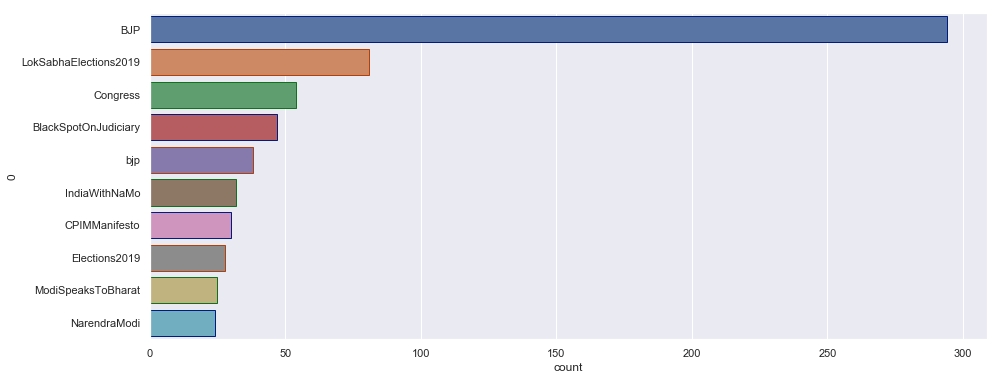

In [14]:
plt.figure(figsize=(15,6))
list_bjp_hashtags=get_hashtags_list('hashtags',df_bjp_clean_tweets)
#list_bjp_hashtags
df_bjp_tags=pd.DataFrame(list_bjp_hashtags)
df_bjp_tags.head()
sns.countplot(y = 0,
              data = df_bjp_tags,
              order = df_bjp_tags[0].value_counts().iloc[:10].index,
              edgecolor=sns.color_palette("dark", 3))
plt.show()

# Let's see the top 10 trending hashtags for Congress related tweets

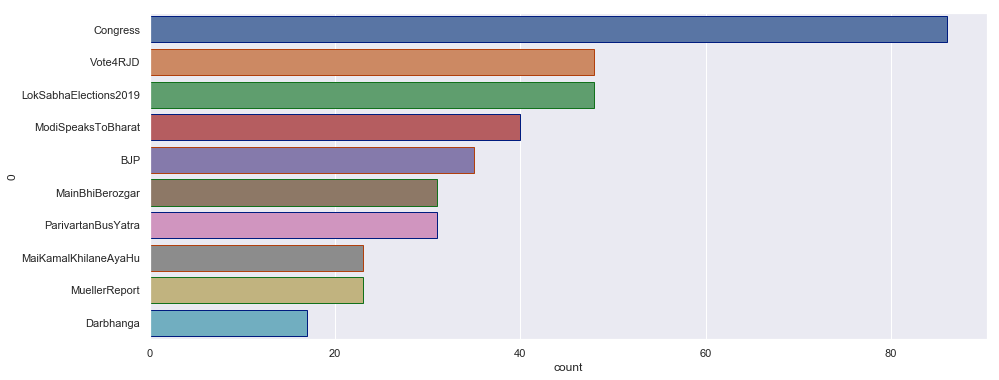

In [15]:
list_congress_hashtags=get_hashtags_list('hashtags',df_congress_clean_tweets)
list_congress_hashtags
df_congress_tags=pd.DataFrame(list_congress_hashtags)
df_congress_tags.head()

#Plot the graph
plt.figure(figsize=(15,6))
sns.countplot(y = 0,
              data = df_congress_tags,
              order = df_congress_tags[0].value_counts().iloc[:10].index,
              edgecolor=sns.color_palette("dark", 3))
plt.show()

### Let's see from where most of the tweets come for each party

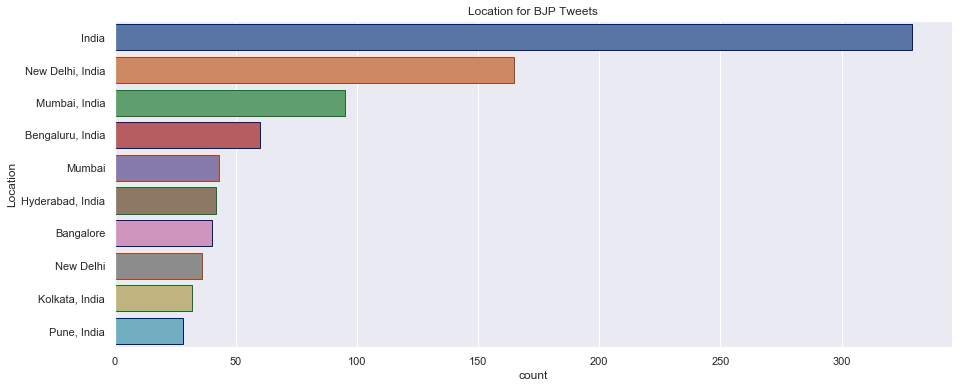

In [16]:
#Plot the graph
plt.figure(figsize=(15,6))
sns.countplot(y = df_bjp_clean_tweets['Location'],
              data = df_bjp_clean_tweets,
              order = df_bjp_clean_tweets['Location'].value_counts().iloc[:10].index,
              edgecolor=sns.color_palette("dark", 3)).set_title('Location for BJP Tweets')
plt.show()
#df_bjp_clean_tweets['Location'].value_counts()

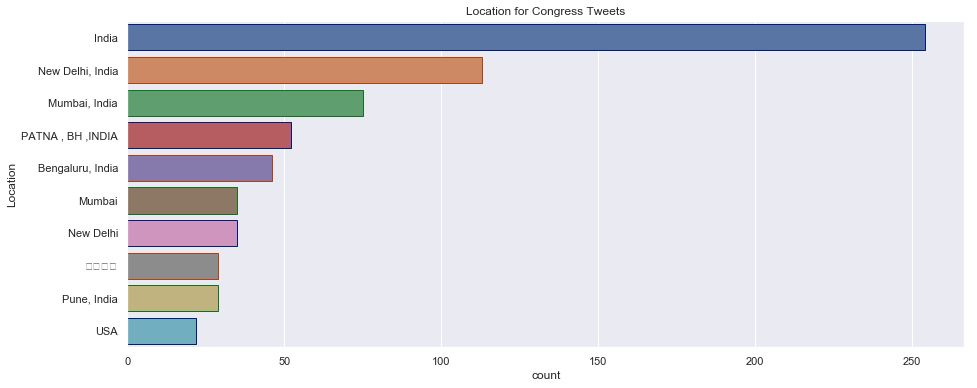

In [17]:
#Plot the graph
plt.figure(figsize=(15,6))
sns.countplot(y = df_congress_clean_tweets['Location'],
              data = df_congress_clean_tweets,
              order = df_congress_clean_tweets['Location'].value_counts().iloc[:10].index,
              edgecolor=sns.color_palette("dark", 3)).set_title('Location for Congress Tweets')
plt.show()
#df_bjp_clean_tweets['Location'].value_counts()

### We've all seen the frequent typos in tweets.. To make sure our model doesn't learn on typo words, we should correct them using the TextBlob..

#### However, since in India, there are lot of common Hindi phrases used to describe the parties and their leaders.. If we force correct the data, we might lose that valuable information . Hence we won't use it for now

In [38]:
df_bjp_clean_tweets.to_csv('BJP_Clean_Tweets.csv')
df_congress_clean_tweets.to_csv('Congress_Clean_Tweets.csv')